### First we define a Decision Tree.
#### A Decision Tree is initialized with some training data and testing data, as well as a list of discrete-valued attributes that each observation will have.

In [ ]:
# Let us first define what it means to be a discrete-valued attribute - each observation will have a list of these items
from abc import ABC
from typing_extensions import Self


class Attribute:
    """An attribute is defined by its set of possible values
    """
    
    def __init__(self, values: set[int]):
        """Initialize an Attribute object

        Args:
            values (set[int]): set of all possible assignments for any instance of this attribute
        """
        self.__values = values
        
    def contains_option(self, v: int) -> bool:
        """Helper method to determine if this attribute has the input value as an option (e.g. - a binary attribute will not have 2 or a greater number as a possible value)

        Args:
            v (int): value in question 

        Returns:
            bool: whether the value is a possible option for this Attribute
        """
        return v in self.__values
    
        
class AttributeInstance:
    """When an observation is created, it will be a given a list of Attributes, and a list of AttributeInstances - a value for said attribute
    """       
    
    def __init__(self, attribute: Attribute, value: int):
        """Create an Attribute Instance object, which needs to know what attribute it is an instance of, and its assignment

        Args:
            attribute (Attribute): The underlying attribute with its list of possible values
            value (int): Value assigned to this particular attribute instance
        """
        assert attribute.contains_option(value)
        self.__attribute = attribute
        self.__value = value
        
    def get_value(self, attribute: Attribute) -> int:
        """If the attribute matches this attribute instance's underlying attribute, return this instance's associated value

        Args:
            v (int): Value to compare to this AttributeInstance's value
        """
        if self.__attribute == attribute:
            return self.__value
        else:
            return None
    
    
class Observation(ABC):
    """An Observation will have a list of attributes and an equally long list of attribute instances
    """
    
    def __init__(self, classification: int, attributes: list[Attribute], values: list[int]):
        """Create an observation with its list of attributes and its list of corresponding values for each attribute

        Args:
            classification (int): Classification for this observation
            attributes (list[Attribute]): List of attributes which apply to this observation
            values (list[AttributeInstance]): List of this observation's values for each of the attributes
        """
        self.__classification = classification
        self.attributes = attributes
        self.__values = [AttributeInstance(attribute=attr, value=v) for attr,v in zip(attributes, values)]
        
    def get_class(self) -> int:
        """Return the class of this observation

        Returns:
            int: this observation's class
        """
        return self.__classification
        
    def get_value(self, attribute: Attribute) -> tuple[int, AttributeInstance]:
        """For the given attribute, return its value for this observation

        Args:
            attribute (Attribute): attribute whose value we want for this observation

        Returns:
            int: value for 
        """
        for attr_inst in self.__values:
            if attr_inst.get_value(attribute=attribute) != None:
                return (attr_inst.get_value(), attr_inst)
        return None
    
    @staticmethod
    def partition(observations: list[Self], attribute: Attribute) -> list[list[Self]]:
        """Class method that - given a list of observations, partition them by their value of the given attribute
        """
        result = []
        seen = {}
        for observation in observations:
            v = observation.get_value(attribute)
            if v in seen.keys():
                # Grab the list of observations associated with this value, and append this observation to it
                result[seen[v]][0].append(observation)
            else:
                seen[v] = len(result)
                result.append([observation])
        
        return result    

In [ ]:
# We need to create a decision tree which - given a list of training Observations - produces a decision tree that will predict classes of unseen Observations
class DecisionTree:
    """This will essentially be a wrapper for a tree node class - the node will do all the work
    """
    
    class DecisionTreeNode:
        """An inner class to help make decisions for observations based on attributes
        """
        
        def __init__(self, observations: list[Observation], attributes: list[Attribute], use_gini_index: bool=False):
            """Initialize a DecisionTreeNode with a given list of observations and attributes the data needs to be split on

            Args:
                observations (list[Observation]): observations, each of which have values for each attribute in attributes
                attributes (list[Attribute]): list of attributes the data still needs to be split on
            """
            self.__gini_index = use_gini_index
            self.__default_prediction = None
            self.__children = {}
            self.__attribute_to_split_on = None
            # First check of all predictions are of the same class
            classes = set([observation.get_class() for observation in observations])
            if len(classes) == 1:
                self.__default_prediction = observations[0].get_class()
            else:
                # See which attribute is the most valuable to split on
                record = float('-inf')
                for attribute in attributes:
                    categories = Observation.partition(observations=observations, attribute=attribute)
                    value = self.__calculate_value(partition=categories)
                    if value > record:
                        record = value
                        self.__attribute_to_split_on = attribute
                        
                if self.__attribute_to_split_on:
                    # We did have attributes to split on
                    categories = Observation.partition(observations=observations, attribute=self.__attribute_to_split_on)
                    new_attributes = [attribute for attribute in attributes if attribute != self.__attribute_to_split_on]
                    for group_class in categories:
                        # Each tuple has a list of observations and the value for the split-on attribute for each list
                        self.__children[group_class[1]] = DecisionTree.DecisionTreeNode(observations=group_class[0], attributes=new_attributes, use_gini_index=self.__gini_index)
                else:
                    # Then we  have no attributes to branch on so go by majority classification
                    counts = {}
                    record = 0
                    for observation in observations:
                        classification = observation.get_class()
                        if classification in counts.keys():
                            counts[classification] += 1
                        else:
                            counts[classification] = 1
                        if counts[classification] > record:
                            record = counts[classification]
                            self.__default_prediction = classification
                    
        def __calculate_value(self, partition: list[list[Observation]]) -> float:
            """Given a partition set of observations with respect to some attribute, return the value of said attribute

            Args:
                partition (list[tuple[list[Observation], AttributeInstance]]): Each tuple corresponds to a list of observations which share the same value for the partitioned attribute

            Returns:
                float: value associated with this partition of observations
            """
            num_observations = sum([len(family) for family in partition])
            classes = set([observation.get_class() for family in partition for observation in family])
            if self.__gini_index:
                pass
            else:
                result = 0
                for family in partition:
                    pass
                        
        
        def predict(self, observation: Observation) -> int:
            """Predict the value of an unseen testing observation

            Args:
                observation (Observation): observation whose class we want to predict

            Returns:
                int: predicted classification for said observation
            """
            if len(self.__children) == 0:
                # This is a node where we went with a default prediction value because we have no attributes to split or all observations in training were of the same class
                return self.__default_prediction
            else:
                return self.__children[observation.get_value(attribute=self.__attribute_to_split_on)].predict(observation=observation)
                
    
    def __init__(self, observations: list[Observation]):
        """Create a decision tree based on the observations

        Args:
            observations (list[Observation]): list of observations that will define our tree
        """
        self.__root = DecisionTree.DecisionTreeNode(observations = observations, attributes = observations[0].attributes)
    
    
    def predict(self, observation: Observation) -> int:
        """Predict the classification of the given observation by having its underlying node do all the work

        Args:
            observation (Observation): observation whose class we want to predict

        Returns:
            int: prediction class of the inputted observation
        """
        return self.__root.predict(observation=observation)

### Let us the reading of observations from a file.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize

class FileObservationsReader:
    """This class takes in data as a pandas data frame along with a block size and parameter for the k nearest neighbors, 
    """
    
    def __init__(self, file_name: str, delimiter: str, id_column_name: str, classification_column_name: str, k : int, n : int):
        """Initialize a FileObservationsReader, which creates a list of observations from the given file
        Args:
            file_name (str): The file from which to read in data
            k (int): The number of closest other points used to guess if a certain point belongs to a given classification
            n (int): The number of different blocks to partition the training points into
        """
        # First let's read in our data
        read_from = open(file_name, "r")
        points_as_strings = read_from.readlines()

        # Let's look at the first line, which reveals the point attributes which are numeric
        header = points_as_strings[0][:-1] # Remember to omit the '\n' character
        attributes = header.split(delimiter)
        class_idx = -1
        id_idx = -1
        attribute_name_indices = []
        # In case keep track of all the values we see for each attribute, which will help us determine if the attribute is discrete or continuous
        # Note that continuous attributes need to be discretized
        attribute_values = {}
        for i, attr in enumerate(attributes):
            if attr == classification_column_name:
                class_idx = i
            elif attr == id_column_name:
                id_idx = i
            else:
                attribute_name_indices.append(i)
                attribute_values[i] = set()
        points_as_strings = points_as_strings[1:]

        read_from.close()
        unique_labels = set()
        self.__labels = []
        self.__names = []
        self.__points_as_dicts = []
        for observation_idx, point_string in enumerate(points_as_strings):
            # First omit the '\n' character in each row of data corresponding to a point
            point_attributes = point_string[:-1].split(delimiter)

            # Record the unique id and class of this point
            self.__labels.append(int(point_attributes[class_idx]))
            unique_labels.add(int(point_attributes[class_idx]))
            self.__names.append(point_attributes[id_idx])

            # Turn this point into a dictionary
            point_as_dict = {}

            # Record all attribute elements of the points 
            for idx in attribute_name_indices:
                attribute_values[idx].add(point_attributes[idx])
                point_as_dict[idx] = point_attributes[idx]
                
            point_as_dict[id_column_name] = self.__names[observation_idx]
            point_as_dict[classification_column_name] = self.__labels[observation_idx]
            self.__points_as_dicts.append(point_as_dict)
 
        # We need to look through each of the attribute value sets, and see which are continuous
        # The following 3 dictionaries map attribute indices (as they appear in the table) to the set of possible values they take on
        integer_discrete_attributes = {}
        continuous_attributes = {}
        named_discrete_attributes = {}
        for idx, values in attribute_values.items():
            for string in values:
                if string.isdigit():
                    # Discrete attribute
                    if idx in integer_discrete_attributes.keys():
                        integer_discrete_attributes[idx].add(int(string))
                    else:
                        integer_discrete_attributes[idx] = set([int(string)])
                else:
                    # See if it is a float - otherwise it is some discrete attribute
                    try:
                        if idx in continuous_attributes.keys():
                            continuous_attributes[idx].append(float(string))
                        else:
                            continuous_attributes[idx] = [float(string)]
                    except:
                        # Not a float
                        if idx in named_discrete_attributes.keys():
                            named_discrete_attributes[idx].add(string)
                        else:
                            named_discrete_attributes[idx] = set([string])
        
        # Next we should normalize and then discretize the continuous attributes
        def classify(x: float) -> int:
            """Depending on the value of a float - between 0 and 1 - give one of four discrete classifications

            Args:
                x (float): the float to classify

            Returns:
                int: the classification of said float
            """
            if x < 0.25:
                return 0
            elif x < 0.5:
                return 1
            elif x < 0.75:
                return 2
            else:
                return 3
        # Use that function
        for attr_idx in continuous_attributes.keys():
            array = np.array(continuous_attributes[attr_idx])
            normalized = normalize(X=array, norm='l2', axis=1, copy=True).tolist()
            continuous_attributes[attr_idx] = [classify(x) for x in normalized]
            
        # Now turn the named discrete attributes into integers
        for attr_idx, possible_names in named_discrete_attributes.items():
            # TODO
            pass
                    
        # Now we can create our list of attributes, and all possible values for said attributes
        

        # Now we are ready to create a list of observations
        self.__observations = []
        # Each numerical attribute must be discretized
        # TODO: next
        # TODO: NON-discretized data?
        
        # For each data point, store its actual label keyed by its id
        self.__values = {}
        
        # Store our model's TEST predictions of each point's label by that point's id in the TEST set
        self.__test_predictions = {}
        # Store our model's TRAIN predictions of each point's label by that point's id in the TRAIN set
        self.__train_predictions = {}
        
        # This dictionary maps point id to that point's vector
        point_vectors = {}
        
        # Record all of our points
        for index, row in enumerate(self.__points_as_dicts):
            self.__values[row[id_column_name]] = row[classification_column_name]
            point_vectors[row[id_column_name]] = self.__normalized_data_array[index]
            self.__test_predictions[row[id_column_name]] = None
            self.__train_predictions[row[id_column_name]] = None
            
                    
    def plot_predictions(self):
        # If we do not have two-dimensional data, do not plot
        if self.__raw_data_array.shape[1] != 2:
            return

        # Plot our data with its actual classifications
        fig, ax = plt.subplots()
        scatter = ax.scatter(self.__raw_data_array[:, 0], self.__raw_data_array[:, 1], c=self.__labels)
        # Produce a legend with the unique colors from the scatter
        # Source: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html#sphx-glr-gallery-lines-bars-and-markers-scatter-with-legend-py
        legend = ax.legend(*scatter.legend_elements(),
                            loc="lower left", title="Classes")
        ax.add_artist(legend)
        plt.title("Model Data")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()
        fig.clear()
        
        # Now do the dame with predictions
        fig, ax = plt.subplots()
        scatter = ax.scatter(self.__raw_data_array[:, 0], self.__raw_data_array[:, 1], c=[self.__test_predictions[name] for name in self.__names])
        # Produce a legend with the unique colors from the scatter
        # Source: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html#sphx-glr-gallery-lines-bars-and-markers-scatter-with-legend-py
        # legend = ax.legend(*scatter.legend_elements(),
        #                     loc="lower left", title="Classes")
        # ax.add_artist(legend)
        plt.title("Model Test Prediction")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()
        fig.clear()

### Now we create an extension of the Observation class with images.

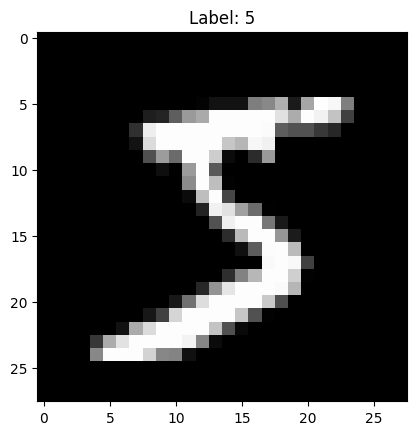

<class 'numpy.ndarray'>
(1, 28, 28)
Class: 5


In [ ]:
# The following line was necessary to import the MNIST images.
# Source: https://stackoverflow.com/questions/78668638/unable-to-load-mnist-data-set-due-to-ssl-error-in-keras-load-data-function
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context

# Libraries to include data and reading it in as images and arrays
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load MNIST dataset as images
train_dataset_as_images = dsets.MNIST(root='./data', train=True, download=True, transform=None)
test_dataset_as_images = dsets.MNIST(root='./data', train=False, download=True, transform=None)

# Load the MNIST dataset as arrays
train_dataset_as_arrays = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataset_as_arrays = [(t.numpy(), c) for t,c in train_dataset_as_arrays]
test_dataset_as_arrays = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_dataset_as_arrays = [(t.numpy(), c) for t,c in test_dataset_as_arrays]

# Display the first sample image
first_image, first_label = train_dataset_as_images[0]
plt.imshow(first_image, cmap='gray')
plt.title(f"Label: {first_label}")
plt.show()

# Display said image as an array
first_image_array, first_label = train_dataset_as_arrays[0]
print(type(first_image_array))
print(first_image_array.shape)
print(f"Class: {first_label}")